In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
import time

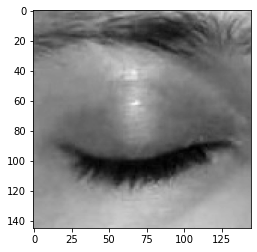

In [2]:
DATADIR = "dataset_drowsiness/train"

CATEGORIES = ["Closed", "Open"]

for category in CATEGORIES:  # do eye open and close
    path = os.path.join(DATADIR,category)  # create path to eye open and close
    for img in os.listdir(path):  # iterate over each image per eye open and close
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display

        break
    break

In [3]:
print(img_array)       ## printing to see one image array

[[ 82  80  77 ... 129 123 124]
 [ 84  83  80 ... 115 114 114]
 [ 84  84  82 ... 109 105 109]
 ...
 [101 101 100 ... 110 111 110]
 [101 101 102 ... 111 111 108]
 [101 100 102 ... 111 110 108]]


In [4]:
print(img_array.shape)      ## taking a look into the image shape

(145, 145)


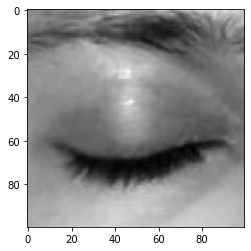

In [5]:
## resizing image
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [6]:
import random

## preparing the training data set
training_data = []

data_dir = "dataset_drowsiness/train"
categories = ['Closed','Open']
image_size = 100
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for image in os.listdir(path):
        try:
            image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(image_array, (image_size, image_size))
            training_data.append([new_array, class_num])
        except Exception as e:
            print(e)

random.shuffle(training_data)

In [7]:
## preparing the testing dataset
testing_data = []

data_dir = "dataset_drowsiness/test"
categories = ['Closed','Open']
image_size = 100
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for image in os.listdir(path):
        try:
            image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(image_array, (image_size, image_size))
            testing_data.append([new_array, class_num])
        except Exception as e:
            print(e)

random.shuffle(testing_data)

In [8]:
## checking the sizes
print(len(training_data), len(testing_data))

1234 218


In [9]:
## splitting train set into X_train and y_train
X_train = []
y_train = []

for features, label in training_data:
    X_train.append(features)
    y_train.append(label)
    
X_train = np.array(X_train).reshape(-1, image_size, image_size, 1)
X_train.shape

(1234, 100, 100, 1)

In [10]:
## splitting test set into X_test and y_test
X_test = []
y_test = []

for features, label in training_data:
    X_test.append(features)
    y_test.append(label)
    
X_test = np.array(X_test).reshape(-1, image_size, image_size, 1)
X_test.shape

(1234, 100, 100, 1)

In [11]:
## saving the dataset splits in our device so we don't have to redo it on every run
import pickle

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

In [12]:
pickle_in = open("X_train.pickle","rb")
X_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("y_train.pickle","rb")
y_train = pickle.load(pickle_in)
pickle_in.close()

X_train.shape, len(y_train)

((1234, 100, 100, 1), 1234)

In [13]:
pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_in = open("X_test.pickle","rb")
X_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("y_test.pickle","rb")
y_test = pickle.load(pickle_in)
pickle_in.close()

X_test.shape, len(y_test)

((1234, 100, 100, 1), 1234)

In [14]:
## Normalising data
X_train = X_train/255.0
y_train = np.array(y_train)

X_test = X_test/255.0
y_test = np.array(y_test)

In [15]:
## setting the variable parameters for this model
dense_layers = [0]
layer_sizes = [128]
conv_layers = [4]
total_epochs = 5

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            ## Generating a name for tensorboard log
            NAME = "{}-conv-{}-nodes-{}-dense-{}-epochs-{}".format(conv_layer, layer_size, dense_layer,total_epochs, int(time.time()))
            tensorboard = TensorBoard(log_dir=r"logs/{}".format(NAME))

            model = Sequential()    ## declaring the model
            
            ## first convolution layer
            model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2)))
            
            ## we can add the nect convolution layers dynamically
            for i in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
            
            ## flattening the convolution to feed it into the dense layer
            model.add(Flatten())
            
            ## Adding the dense layers dynamically
            for i in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            ## last dense layer to get our probability distribution
            model.add(Dense(1))
            model.add(Activation("sigmoid"))
            
            model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
            
            ## fitting the model
            model.fit(X_train, y_train, batch_size = 5, epochs=total_epochs, validation_split = 0.3, callbacks=[tensorboard])
            
            ## testing the model
            val_loss, val_acc = model.evaluate(X_test, y_test)
            print(val_loss, val_acc)

Epoch 1/5
173/173 [==============================] - 17s 94ms/step - loss: 0.5022 - accuracy: 0.7405 - val_loss: 0.1876 - val_accuracy: 0.9488
Epoch 2/5
173/173 [==============================] - 16s 94ms/step - loss: 0.1696 - accuracy: 0.9392 - val_loss: 0.1828 - val_accuracy: 0.9380
Epoch 3/5
173/173 [==============================] - 19s 110ms/step - loss: 0.0888 - accuracy: 0.9683 - val_loss: 0.1771 - val_accuracy: 0.9380
Epoch 4/5
173/173 [==============================] - 20s 117ms/step - loss: 0.0766 - accuracy: 0.9689 - val_loss: 0.1339 - val_accuracy: 0.9596
Epoch 5/5
39/39 [==============================] - 7s 176ms/step - loss: 0.0558 - accuracy: 0.9814
0.05581813305616379 0.981361448764801
